In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
words = open("../data/names.txt", 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [10]:
block_sz = 3
X, Y = [], []

for w in words[:5]:

    print("---")
    print(w)
    print("---")
    context = [0] * block_sz
    for ch in w + ".":
        ix = stoi[ch]
        print(''.join(itos[i] for i in context), " ---> ", itos[ix])
        context = context[1:] + [ix]

---
emma
---
...  --->  e
..e  --->  m
.em  --->  m
emm  --->  a
mma  --->  .
---
olivia
---
...  --->  o
..o  --->  l
.ol  --->  i
oli  --->  v
liv  --->  i
ivi  --->  a
via  --->  .
---
ava
---
...  --->  a
..a  --->  v
.av  --->  a
ava  --->  .
---
isabella
---
...  --->  i
..i  --->  s
.is  --->  a
isa  --->  b
sab  --->  e
abe  --->  l
bel  --->  l
ell  --->  a
lla  --->  .
---
sophia
---
...  --->  s
..s  --->  o
.so  --->  p
sop  --->  h
oph  --->  i
phi  --->  a
hia  --->  .


In [11]:
def create_dataset(words, block_sz=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_sz
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [12]:
len(words)

32033

In [13]:
import random

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = create_dataset(words[:n1])
Xdev, Ydev = create_dataset(words[n1:n2])
Xte, Yte = create_dataset(words[n2:])

In [14]:
Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([182400, 3]), torch.Size([22881, 3]), torch.Size([22865, 3]))

In [31]:
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [32]:
sum(p.nelement() for p in parameters)

11897

In [33]:
for p in parameters:
    p.requires_grad = True

In [34]:
lossi = []
stepi = [0]

In [150]:
for i in range(50000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    stepi.append(stepi[-1]+1)
    lossi.append(loss.log10().item())

# print(loss.item())

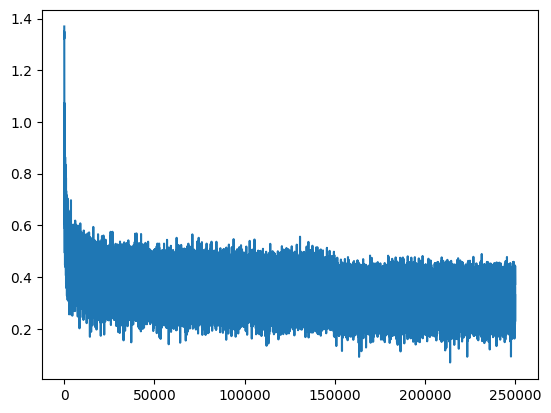

In [151]:
plt.plot(stepi[1:], lossi)

In [152]:
with torch.no_grad():
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print(loss.item())

2.090392589569092


In [153]:
with torch.no_grad():
    emb = C[Xdev]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print(loss.item())

2.1522085666656494


#### Loss when the predicted proabilities are uniform

In [165]:
with torch.no_grad():
    probs = torch.tensor([1/27] * 27)
    logits = torch.multinomial(probs, Ytr.shape[0], replacement=True, generator=g)
    loss = F.cross_entropy(probs, Ytr[3])
    print(loss.item())

3.295836925506592


### Training parameters to give out uniform probabilites

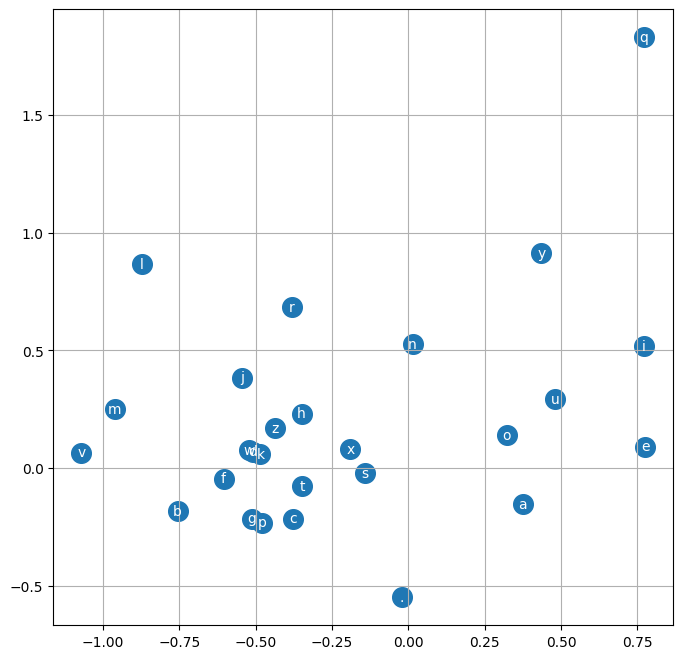

In [204]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")